## Anomaly Detection and Recommender Systems

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import os
from scipy.io import loadmat # used to implement mat file type
import ex8_func as fn
import scipy.optimize as opt

# Update the matplotlib configuration parameters: 
matplotlib.rcParams.update({'font.size': 25, 'font.family': 'serif'})
% matplotlib inline

## 1 Anomaly detection

In this exercise, an anomaly detection algorithm is implemented to detect anomalous behavior in server computers.  The features measure the throughput (mb/s) and latency (ms) of response of each server.  While the servers were operating,  m = 307 examples were collected of how they were behaving, and thus have an unlabeled dataset. It is suspected that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset. 

A Gaussian  model is used  to  detect  anomalous  examples  in  the dataset. First, the analysis starts on a 2D dataset that will allow you to visualize what the algorithm is doing.  On that dataset a Gaussian distribution will be fit and then find the values that have very low probability and hence can be considered anomalies. After that,the anomaly detection algorithm is applied to a larger dataset with many dimensions.  

#### Load Example Dataset

In [2]:
!ls

anomaly_detection_and_recommender_systems.ipynb  ex8_func.py
ex7_func.py					 ex8_func.pyc
ex7_func.pyc					 ex8_movieParams.mat
ex8data1.mat					 ex8_movies.mat
ex8data2.mat					 movie_ids.txt


In [3]:
# Loading Data
directory = os.getcwd() + '/ex8data1.mat'
raw_data = loadmat(directory)
print raw_data.keys()

X = np.array(raw_data['X'])
Xval = np.array(raw_data['Xval'])
yval = np.array(raw_data['yval'])

X.shape, Xval.shape, yval.shape

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']


((307, 2), (307, 2), (307, 1))

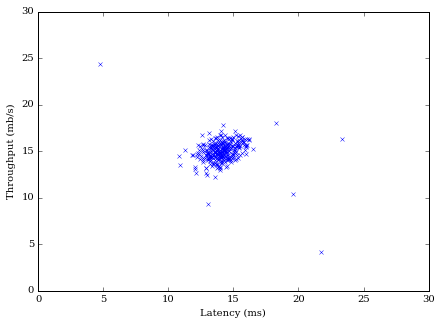

In [4]:
fig,ax = plt.subplots(figsize=(7,5))
ax.plot(X[:,0],X[:,1],'x',ms=4)
ax.set_xlim([0,30])
ax.set_ylim([0,30])
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')

#### Estimate the dataset statistics

In [5]:


mu, sigma2 = fn.estimateGaussian(X)
p = fn.multivariateGaussian(X, mu, sigma2)

p[:10], p.shape

(array([ 0.06470829,  0.05030417,  0.07245035,  0.05031575,  0.06368497,
         0.04245832,  0.04790945,  0.03651115,  0.0186658 ,  0.05068826]),
 (307,))

In [6]:
stsize= 300
# X1 = np.linspace(np.min(X[:,0])+5,np.max(X[:,0])-5, stsize)
# X2 = np.linspace(np.min(X[:,1])+5,np.max(X[:,0])-5, stsize)
X1 = np.linspace(0,30, stsize)
X2 = np.linspace(0,30, stsize)
J_vals = np.zeros((stsize,stsize))

for i in range(stsize):
    for j in range(stsize):
        t = np.array([X1[i],  X2[j]])
        J_vals[i,j] =fn.multivariateGaussian(t.reshape(1,2), mu, sigma2)

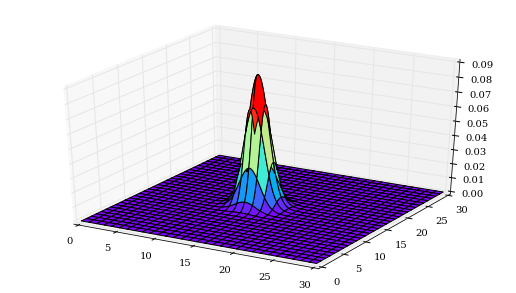

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111, projection='3d',)
a, b = np.meshgrid(X1, X2)
ax.plot_surface(a, b, J_vals.T,cmap='rainbow')

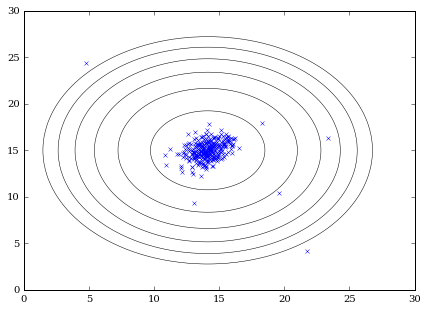

In [8]:
J_vals_c = J_vals.T
fig,ax = plt.subplots(figsize=(7,5))
ax.contour(a, b, J_vals_c ,np.logspace(-20, 10, 10),linewidths=0.5,colors='k')
ax.plot(X[:,0],X[:,1],'bx',ms=4);

 #### Find Outliers

In [9]:


# the vector of probabilities
pval = fn.multivariateGaussian(Xval, mu, sigma2)
# compute the epsilon which gives best F1 score
bestF1, bestEpsilon = fn.selectThreshold(yval, pval)

print 'Best epsilon found using cross-validation: {}\n'.format( round(bestEpsilon,7))
print 'Best F1 on Cross Validation Set:  {}%\n'.format( bestF1*100)

Best epsilon found using cross-validation: 8.99e-05

Best F1 on Cross Validation Set:  87.5%



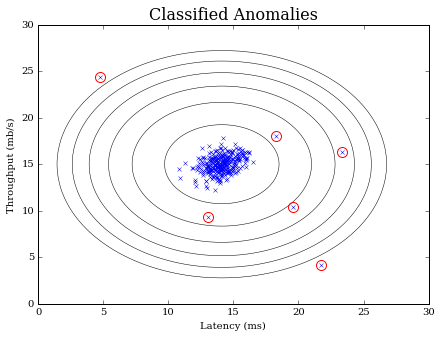

In [10]:
#  Find the outliers in the training set and plot the
outliers = np.where(p < bestEpsilon)[0]
# replot the test set and show classified anomalies
J_vals_c = J_vals.T
fig,ax = plt.subplots(figsize=(7,5))
ax.contour(a, b, J_vals_c ,np.logspace(-20, 10, 10),linewidths=0.5,colors='k')
ax.plot(X[outliers,0] , X[outliers,1],'o',c='r',ms=10,mew=1,fillstyle='none')
ax.plot(X[:,0],X[:,1],'bx',ms=4)
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')
ax.set_title('Classified Anomalies',fontsize=16)


## Multidimensional Outliers

In [11]:
# Loading Data
directory = os.getcwd() + '/ex8data2.mat'
raw_data = loadmat(directory)
print raw_data.keys()

X = np.array(raw_data['X'])
Xval = np.array(raw_data['Xval'])
yval = np.array(raw_data['yval'])

X.shape, Xval.shape, yval.shape

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']


((1000, 11), (100, 11), (100, 1))

In [12]:
mu,sigma2 = fn.estimateGaussian(X)
mu_multi,sigma2_multi = fn.estimateMulti(X)

# cval set
p_val =  fn.multivariateGaussian(Xval, mu, sigma2)
p_multi_val =  fn.multivariateGaussian(Xval, mu_multi, sigma2_multi)
# find the best threshold
bestF1, bestEpsilon = fn.selectThreshold(yval, p_val)
bestF1_m , bestEpsilon_m  = fn.selectThreshold(yval, p_multi_val)
# test set
p =  fn.multivariateGaussian(X, mu, sigma2)
p_multi =  fn.multivariateGaussian(X, mu_multi, sigma2_multi)

print 'Best epsilon found using cross-validation: {}\n'.format(round(bestEpsilon,20))
print 'Sec epsilon found using cross-validation: {}\n' .format(round(bestEpsilon_m,20))

print 'Best F1 on Cross Validation Set:  %{}\n'.format(bestF1*100)
print 'Sec best F1_mul on Cross Validation Set:  %{}\n'.format(bestF1_m*100)

print '# Outliers found: {}\n'.format(np.sum(p<bestEpsilon))
print '# Outliers2 found: {}\n'.format(np.sum(p<bestEpsilon_m))

Best epsilon found using cross-validation: 3.45e-18

Sec epsilon found using cross-validation: 4.4e-18

Best F1 on Cross Validation Set:  %61.5384615385

Sec best F1_mul on Cross Validation Set:  %55.1724137931

# Outliers found: 117

# Outliers2 found: 141



## 2 Recommender Systems

In  this  part  of  the  exercise, the  collaborative   filtering learning algorithm will be applied to a dataset of movie ratings.

#### Loading movie ratings dataset

In [13]:
# Loading Data
directory = os.getcwd() + '/ex8_movies'
raw_data = loadmat(directory)
print raw_data.keys()

Y = np.array(raw_data['Y'])
R = np.array(raw_data['R'])

print Y.shape, R.shape
print '\nAverage rating for movie 1 (Toy Story): {} over 5\n'.format(np.mean(Y[0,:][np.array(R[0,:],dtype=bool)]))

['Y', 'R', '__version__', '__header__', '__globals__']
(1682, 943) (1682, 943)

Average rating for movie 1 (Toy Story): 3.87831858407 over 5



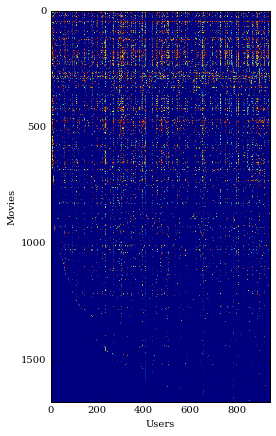

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')

#### Collaborative Filtering Cost Function

In [15]:
# Load pre-trained weights
directory = os.getcwd() + '/ex8_movieParams'
raw_data = loadmat(directory)
print raw_data.keys()

num_features = np.array(raw_data['num_features'])
num_users = np.array(raw_data['num_users'])
num_movies =  np.array(raw_data['num_movies'])
print num_features,num_movies,num_users

X = np.array(raw_data['X'])
Theta = np.array(raw_data['Theta'])
print X.shape, Theta.shape 

['num_features', '__header__', '__globals__', 'num_users', 'X', 'Theta', '__version__', 'num_movies']
[[10]] [[1682]] [[943]]
(1682, 10) (943, 10)


In [16]:
# Reduce the data set size so that this runs faster
num_users = 4 
num_movies = 5
num_features = 3

X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

X.shape,Theta.shape,Y.shape,R.shape

((5, 3), (4, 3), (5, 4), (5, 4))

In [17]:
params = np.concatenate((X.ravel(), Theta.ravel()))
J,grad = fn.cofiCostFunc(params,Y, R, num_users, num_movies, num_features)

print 'Cost at loaded parameters:{}'.format(round(J,2))

Cost at loaded parameters:22.22


####  Collaborative Filtering Gradient

In [18]:


# Short hand for cost function
costFunc = lambda p : fn.cofiCostFunc(p,Y, R, num_users, num_movies, num_features)
cost , grad = costFunc(params)
numgrad = fn.computeNumericalGradient(costFunc, params)

In [19]:
# Visually examine the two gradient computations.  The two columns you get should be very similar. 
print 'The below two columns you get should be very similar.\n'
print '(Left-Analytical Gradient, Right-Your Numerical Gradient )\n'
for  e in range(params.size/4):
    print round(grad[e],4) ,' ---- ', round(numgrad[e],4)

The below two columns you get should be very similar.

(Left-Analytical Gradient, Right-Your Numerical Gradient )

-2.529  ----  -2.529
7.5757  ----  7.5757
-1.8998  ----  -1.8998
-0.5682  ----  -0.5682
3.3527  ----  3.3527
-0.5234  ----  -0.5234


#### Collaborative Filtering Cost and Gradient Regularization 

In [20]:

lambda_ = 1.5
J,grad = fn.cofiCostFunc(params,Y, R, num_users, num_movies, num_features,lambda_)
print 'Cost at loaded parameters (lambda = 1.5): {}'.format(round(J,2))

Cost at loaded parameters (lambda = 1.5): 31.34


#### Entering ratings for a new user

In [21]:
# Store all movies in a dictionary
movieList = {}
with open('movie_ids.txt') as f:
    for line in f:
        e = line.strip('\n').split(' ')
        movieList[int(e[0])-1] = ' '.join(e[1:])

movieList[0]

'Toy Story (1995)'

In [22]:
# Initialize my ratings
my_ratings = np.zeros((1682, 1))
# select a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[0] = 4
my_ratings[6] = 3
my_ratings[97] = 2
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

In [23]:
for i in range(my_ratings.size):
    if my_ratings[i]!=0:
        print('Rated {} with {} stars.'.format(movieList[i], str(int(my_ratings[i]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


#### Learning Movie Ratings

In [24]:
# Loading Data
directory = os.getcwd() + '/ex8_movies'
raw_data = loadmat(directory)
print raw_data.keys()

# Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
Y = np.array(raw_data['Y'])
R = np.array(raw_data['R'])

print Y.shape, R.shape, my_ratings.shape

['Y', 'R', '__version__', '__header__', '__globals__']
(1682, 943) (1682, 943) (1682, 1)


In [25]:
# Add our own ratings to the Y matrix 
Yn = np.concatenate((my_ratings,Y), axis=1)

# create R vector for my_ratings
my_R = np.array(my_ratings!=0,dtype=int)

# Add our own ratings to the R matrix 
Rn = np.concatenate((my_R,R), axis=1)

Yn.shape, Rn.shape

((1682, 944), (1682, 944))

In [26]:


# Normalize Ratings
Ynorm , mu = fn.normalizeRatings(Yn, Rn)
Ynorm.mean()

7.3389861157429883e-19

In [27]:
#  Useful Values
num_movies = Ynorm.shape[0]
num_users = Ynorm.shape[1]
num_features = 10

# Set initial parameters
X = np.random.random((num_movies,num_features))
Theta = np.random.random((num_users,num_features))
# ravel parameters to a single vector
initial_params = np.concatenate((X.ravel(), Theta.ravel()))

#### Optimization

In [28]:


# set lambda
lambda_ = 10.
# Short hand for cost function to be minimized
costFunc = lambda p : fn.cofiCostFunc(p,Ynorm, Rn, num_users, num_movies, num_features,lambda_)
cost , grad = costFunc(initial_params)
cost

429608.23146756931

In [29]:
# Minimize a scalar function of one or more variables using a truncated Newton (TNC) algorithm
fmin = opt.minimize(fun=costFunc, 
                    x0=initial_params,
                    method='CG', 
                    jac=True, 
                    options={'maxiter':100})

In [30]:
# Unfold the returned theta back into X and Theta
X = fmin.x[0:num_features*num_movies].reshape(num_movies, num_features)
Theta = fmin.x[num_features*num_movies:].reshape(num_users, num_features)
X.shape,Theta.shape

((1682, 10), (944, 10))

#### Recommendation for you

In [31]:
p = X.dot(Theta.T)
my_predictions = p[:,0].reshape(num_movies,1) + mu
idx = np.argsort(my_predictions, axis=0)[::-1]

print("Top 10 movie predictions:")
for i in range(20):
    j = int(idx[i])
    print('Predicted rating of {} for movie {}.'.format(round(float(my_predictions[j]),2), movieList[j]))

Top 10 movie predictions:
Predicted rating of 5.0 for movie Santa with Muscles (1996).
Predicted rating of 5.0 for movie Someone Else's America (1995).
Predicted rating of 5.0 for movie Great Day in Harlem, A (1994).
Predicted rating of 5.0 for movie Prefontaine (1997).
Predicted rating of 5.0 for movie Aiqing wansui (1994).
Predicted rating of 5.0 for movie Saint of Fort Washington, The (1993).
Predicted rating of 5.0 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 5.0 for movie They Made Me a Criminal (1939).
Predicted rating of 5.0 for movie Star Kid (1997).
Predicted rating of 4.64 for movie Pather Panchali (1955).
Predicted rating of 4.52 for movie Shawshank Redemption, The (1994).
Predicted rating of 4.52 for movie Wrong Trousers, The (1993).
Predicted rating of 4.51 for movie Maya Lin: A Strong Clear Vision (1994).
Predicted rating of 4.5 for movie Anna (1996).
Predicte

note: The reason why above predictions is different from the ones in the fig4 of the ex8.pdf is an errata in the pdf. The actual optimizer parameter should be normalized Y while the figure shows results with non normalized Y. If you change Ynorm with Yn you will get the same results with the fig4. 